# Part 1: Data Ingestion


In this notebook we will learn how to **Ingest** different data sources to our **Feature Store**. Specifically, this patient data has been successfully used to treat hospitalized COVID-19 patients prior to their condition becoming severe or critical. To do this we will use a medical dataset which includes three types of data:  
- **Healthcare systems**: Batch updated dataset, containing different lab test results (Blood test results for ex.).
- **Patient Records**: Static dataset containing general patient details.
- **Real-time sensors**: Real-Time patient metric monitoring sensor.  

<img src="../../_static/images/feature_store_demo_diagram.png" width="600px" />

We will walk through creation of ingestion pipeline for each datasource with all the needed preprocessing and validation. We will run the pipeline locally within the notebook and then launch a real-time function to **ingest live data** or schedule a cron to run the task when needed.

## Environment Setup

Since our work is done in a this project scope, first define the project itself for all our MLRun work in this notebook.

In [ ]:
import mlrun
from os import getenv

mlrun.set_environment(project='fsdemo', user_project=True)
# location of the output data files
data_path = f"{getenv('V3IO_HOME_URL')}/demos/feature-store/data/"

In [2]:
def move_timestamps(df, shift='0s'):
    ''' Update timetsamps to current time so we can see live aggregations '''
    now = pd.to_datetime('now')
    max_time = df['timestamp'].max()
    time_shift = now-max_time
    tmp_df = df.copy()
    tmp_df['timestamp'] = tmp_df['timestamp'].apply(lambda t: t + time_shift + pd.to_timedelta(shift))
    
    return tmp_df

## Create Ingestion Pipeline With MLRun
In this section we will ingest the lab measurements data using MLRun and Storey. Storey is the underlying implementation of the feature store which is used by MLRun. It is the engine that allows you to define and execute complex graphs that create the feature engineering pipeline. With storey, you can define source, transformations and targets, many actions are available as part of the Storey library, but you can define additional actions easily. We will see these custom actions in later sections.

For the execution, it is possible to also use Spark. The main difference between Storey and Spark pipelines is that Storey blocks are built for Real-Time workloads while Spark is more Batch oriented.  
We will now do the following:
- Create the `measurements` FeatureSet
- Define Preprocessing graph including aggregations
- Ingest the data using the defined pipeline

In [3]:
# Import MLRun's Feature Store
import mlrun.feature_store as fs

# Import MLRun's Data Sources to set the wanted ingestion pipeline
from mlrun.datastore.sources import CSVSource, ParquetSource, HttpSource

In [4]:
# Import storey so it will be available on our scope
# when testing the pipeline
import storey

# Define the Lab Measurements FeatureSet
measurements_set = fs.FeatureSet("measurements", 
                                 entities=[fs.Entity("patient_id")], 
                                 timestamp_key='timestamp', 
                                 description="various patient health measurements")

# Get FeatureSet computation graph
measurements_graph = measurements_set.graph

### Define the processing pipeline
- Transformation function
- Sliding window aggregation
- Set targets (NoSQL and Parquet)

In [5]:
# Import pandas and load the sample CSV and load it as a datasource
# for our ingestion
import pandas as pd

measurements_df = pd.read_csv('https://s3.wasabisys.com/iguazio/data/patients/measurements.csv', index_col=0)
measurements_df['timestamp'] = pd.to_datetime(measurements_df['timestamp'])
measurements_df['timestamp'] = measurements_df['timestamp'].astype("datetime64[ms]")
measurements_df = pd.concat([move_timestamps(measurements_df, '-1h'), move_timestamps(measurements_df)]) # update timestamps

Take a look at the measurements dataset. This dataset includes a a single measurement per row. The measurement type is defined by the `source` and `parameter` column. We would like to transform this data, so each patient has multiple measurement columns. To do that, we will need to create a new column for each `source` and `parameter` combination. For example, if `source` is 3 and `parameter` is 0, then our transformed dataset will have the measurement value in a new feature named `sp_3_0`.
Following that, we will create a sliding window aggregation that averages the values across that time window.

In [6]:
measurements_df.head()

,department,patient_id,room,bed,timestamp,source,parameter,measurement
0,01e9fe31-76de-45f0-9aed-0f94cc97bca0,622-37-0180,1,69,2021-05-06 14:27:01.844274,0,0,7.357227
1,01e9fe31-76de-45f0-9aed-0f94cc97bca0,622-37-0180,1,69,2021-05-06 14:27:01.844274,0,1,77.369672
2,01e9fe31-76de-45f0-9aed-0f94cc97bca0,622-37-0180,1,69,2021-05-06 14:27:01.844274,0,2,94.536147
3,01e9fe31-76de-45f0-9aed-0f94cc97bca0,622-37-0180,1,69,2021-05-06 14:27:01.844274,1,0,65.994804
4,01e9fe31-76de-45f0-9aed-0f94cc97bca0,622-37-0180,1,69,2021-05-06 14:27:01.844274,1,1,69.858503


The following code performs the transformation, adds the aggregation and sets the target to store the values to a NoSQL database for online retrieval and parquet files for batch processing.

In [7]:
# Define transform to create sparse dataset for aggregation
# adding an extra column for the specific source-parameter pair's measurement
# ex: source=3, parameter=4, measurement=100 -> add extra column sp_3_4=100
def transform(event):
    event["_".join(['sp', str(event["source"]), str(event["parameter"])])] = event["measurement"]
    return event

# Define Measurement FeatureSet pipeline
measurements_graph.to(
    "storey.Map", _fn="transform"
)

# Get the available source, parameter pairs for our aggregation
sps = list(measurements_df.apply(lambda x: '_'.join(['sp', str(x['source']), str(x['parameter'])]), axis=1).unique())

# Add aggregations on top of the created sparse
# features by the transorm function
for col in sps:
    measurements_set.add_aggregation(name=f'agg_{col}',
                                     column=col,
                                     operations=['avg'],
                                     windows='1h',
                                     period='30m')

# Add default (NoSQL via KV and Parquet) targets to save
# the ingestion results to
measurements_set.set_targets()

You can plot the graph to visalize the pipeline:

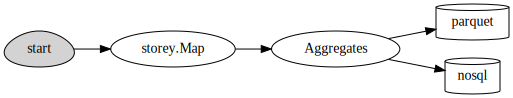

In [8]:
# Plot the ingestion pipeline we defined
measurements_set.plot(rankdir='LR', with_targets=True)

### Run ingestion task using MLRun & Storey

In order to ingest the dataframe to the featureset, use the `ingest` function.

In [9]:
# User our loaded DF as the datasource and ingest it through
# the define pipeline
resp = fs.ingest(measurements_set, measurements_df, 
                 infer_options=fs.InferOptions.default())
resp.head()

,agg_sp_0_0_avg_1h,agg_sp_0_1_avg_1h,agg_sp_0_2_avg_1h,agg_sp_1_0_avg_1h,agg_sp_1_1_avg_1h,agg_sp_1_2_avg_1h,agg_sp_2_0_avg_1h,agg_sp_2_1_avg_1h,agg_sp_2_2_avg_1h,department,...,measurement,sp_0_0,sp_0_1,sp_0_2,sp_1_0,sp_1_1,sp_1_2,sp_2_0,sp_2_1,sp_2_2
patient_id,,,,,,,,,,,,,,,,,,,,,
622-37-0180,7.357227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01e9fe31-76de-45f0-9aed-0f94cc97bca0,...,7.357227,7.357227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
622-37-0180,7.357227,77.369672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01e9fe31-76de-45f0-9aed-0f94cc97bca0,...,77.369672,NaN,77.369672,NaN,NaN,NaN,NaN,NaN,NaN,NaN
622-37-0180,7.357227,77.369672,94.536147,NaN,NaN,NaN,NaN,NaN,NaN,01e9fe31-76de-45f0-9aed-0f94cc97bca0,...,94.536147,NaN,NaN,94.536147,NaN,NaN,NaN,NaN,NaN,NaN
622-37-0180,7.357227,77.369672,94.536147,65.994804,NaN,NaN,NaN,NaN,NaN,01e9fe31-76de-45f0-9aed-0f94cc97bca0,...,65.994804,NaN,NaN,NaN,65.994804,NaN,NaN,NaN,NaN,NaN
622-37-0180,7.357227,77.369672,94.536147,65.994804,69.858503,NaN,NaN,NaN,NaN,01e9fe31-76de-45f0-9aed-0f94cc97bca0,...,69.858503,NaN,NaN,NaN,NaN,69.858503,NaN,NaN,NaN,NaN


In [10]:
# Save the FeatureSet and pipeline definition
measurements_set.save()

## Ingest Patient Details Features  
In this section we will use MLRun to create our patient details datasource.  
We will do the following:
- Create a `patient_details` FeatureSet
- Add preprocessing transformations to the pipeline
    - Map ages to buckets and One Hot Encode them
    - Impute missing values
- Test the processing pipeline with sample data
- Run ingestion pipeline on top of the cluster

### Create the FeatureSet

In [11]:
# add feature set without time column (stock ticker metadata) 
patients_set = fs.FeatureSet("patient_details", entities=[fs.Entity("patient_id")],
                             description="personal and medical patient details")

# Get FeatureSet computation graph
graph = patients_set.spec.graph

## Define the computation pipeline

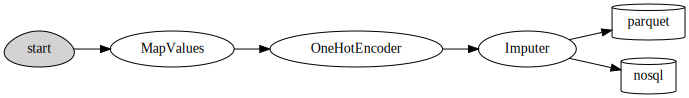

In [12]:
# Define age buckets for our age value mapping
personal_details = {'age': {'ranges': [{'range': [0, 3], "value": "toddler"},
                                      {'range': [3, 18], "value": "child"},
                                      {'range': [18, 65], "value": "adult"},
                                      {'range': [65, 120], "value": "elder"}]}}

# Define one hot encoding values map
one_hot_encoder_mapping = {'age_mapped': ['toddler', 'child', 'adult', 'elder']}

# Import MLRun's FeatureStore steps for easy
# use in our pipeline
from mlrun.feature_store.steps import *

# Define the pipeline for our FeatureSet
graph.to(MapValues(mapping=personal_details, with_original_features=True))\
     .to(OneHotEncoder(mapping=one_hot_encoder_mapping))\
     .to(Imputer(method='values', default_value=1, mapping={}))

# Add default NoSQL & Parquet ingestion targets
patients_set.set_targets()

# Plot the FeatureSet pipeline
patients_set.plot(rankdir='LR', with_targets=True)

### Test the Feature transformation pipeline

Creating a transformation pipeline requires some trial and error. Therefore, it is useful to run the pipeline in memory without storing the resultant data. For this purpose, `infer` is used. This function receives as input any sample DataFrame, performs all the graph steps and outputs the transformed DataFrame.

In [13]:
# Load the sample patient details data
patients_df = pd.read_parquet('https://s3.wasabisys.com/iguazio/data/patients/patient_details.parquet')

# Run local ingestion test
fs.infer(patients_set, patients_df.head())

,age_mapped_toddler,age_mapped_child,age_mapped_adult,age_mapped_elder,department,room,bad,gender,age
patient_id,,,,,,,,,
622-37-0180,0,0,0,1,01e9fe31-76de-45f0-9aed-0f94cc97bca0,1,69,Male,65
838-21-8151,0,0,0,1,01e9fe31-76de-45f0-9aed-0f94cc97bca0,1,38,Female,70
305-90-1613,0,0,1,0,01e9fe31-76de-45f0-9aed-0f94cc97bca0,2,95,Male,55
311-12-1668,0,0,0,1,01e9fe31-76de-45f0-9aed-0f94cc97bca0,1,76,Female,89
584-74-3407,0,0,0,1,01e9fe31-76de-45f0-9aed-0f94cc97bca0,2,47,Male,87


### Save the FeatureSet and run full ingestion task

Once you are satisfied with the transformation pipeline, ingest that full DataFrame and store the data.

In [14]:
# Save the FeatureSet
patients_set.save()

# Run Ingestion task
resp = fs.ingest(patients_set, patients_df, 
                 infer_options=fs.InferOptions.default())

### Start Immediate or Scheduled Ingestion Job (over Kubernetes)

Another useful method to ingest data, is by creating a Kubernetes job. This may be necessary to process large amounts of data as well as to process any recurring data. With MLRun it is easy to take the pipeline and run it as a job. This is done by:

1. Define a source, specifically here we define a parquet file source
2. Define a configuration where `local` is set to `False`
3. Mount to the provisioned storage by calling `auto_mount`
4. Run `ingest` with the source and run configuration

In [15]:
source = ParquetSource('pq', 'https://s3.wasabisys.com/iguazio/data/patients/patient_details.parquet')
config = fs.RunConfig(local=False).apply(mlrun.platforms.auto_mount())
fs.ingest(patients_set, source, run_config=config)

> 2021-05-06 15:27:08,769 [info] starting run patient_details_ingest uid=76f197b8ab3347d1b995a5ea55d0a98a DB=http://mlrun-api:8080
> 2021-05-06 15:27:09,022 [info] Job is running in the background, pod: patient-details-ingest-g9hgn
> 2021-05-06 15:27:15,073 [info] starting ingestion task to store://feature-sets/fsdemo-admin/patient_details:latest
> 2021-05-06 15:27:15,745 [info] ingestion task completed, targets:
> 2021-05-06 15:27:15,746 [info] [{'name': 'parquet', 'kind': 'parquet', 'path': 'v3io:///projects/fsdemo-admin/fs/parquet/sets/patient_details-latest.parquet', 'status': 'created', 'updated': '2021-05-06T15:27:15.432576+00:00'}, {'name': 'nosql', 'kind': 'nosql', 'path': 'v3io:///projects/fsdemo-admin/fs/nosql/sets/patient_details-latest', 'status': 'created', 'updated': '2021-05-06T15:27:15.432947+00:00'}]
> 2021-05-06 15:27:15,936 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
fsdemo-admin,...55d0a98a,0,May 06 15:27:14,completed,patient_details_ingest,job-type=feature-ingestfeature-set=store://feature-sets/fsdemo-admin/patient_detailsv3io_user=adminkind=jobowner=adminhost=patient-details-ingest-g9hgn,,"infer_options=63featureset=store://feature-sets/fsdemo-admin/patient_detailssource={'kind': 'parquet', 'name': 'pq', 'path': 'https://s3.wasabisys.com/iguazio/data/patients/patient_details.parquet'}targets=None",featureset=store://feature-sets/fsdemo-admin/patient_details:latest,


to track results use .show() or .logs() or in CLI: 
!mlrun get run 76f197b8ab3347d1b995a5ea55d0a98a --project fsdemo-admin , !mlrun logs 76f197b8ab3347d1b995a5ea55d0a98a --project fsdemo-admin
> 2021-05-06 15:27:18,259 [info] run executed, status=completed


## Real-time Early-Sense Sensor Ingestion (HTTP or Stream Processing With Nuclio)  
In this section we will use MLRun to create our Early Sense Sensor datasource.  
We will do the following:
- Create early sense FeatureSet
- Add Preprocessing transformations to the Pipeline using custom functions
    - Drop and Rename columns
    - Aggregations
- Add Feature Validator to detect bad sensor readings
- Test the processing pipeline with sample data
- Deploy the FeatureSet ingestion service as a live rest endpoint

In [16]:
early_sense_set = fs.FeatureSet("early_sense", entities=[fs.Entity("patient_id")], timestamp_key='timestamp',
                                description="real time patient bed sensor data")

### Define data validation & quality policy

We can define validations on the feature level. For example, define here validation to check if the heart-rate value is between 0 and 220 and respitory rate is between 0 and 25.

In [17]:
from mlrun.features import MinMaxValidator

early_sense_set["hr"] = fs.Feature(validator = MinMaxValidator(min=0, max=220, severity="info"))
early_sense_set["rr"] = fs.Feature(validator = MinMaxValidator(min=0, max=25, severity="info"))

### Define custom processing classes

In the previous sections we used transformation steps that are available as part of Storey. Here we show how to create custom transformation classes. We will later run these functions as part of a Nuclio serverless real-time function, therefore, we also use the nuclio `start-code` and `end-code` comments.

In [18]:
# nuclio: start-code

In [19]:
# We will import storey here too so it will
# be included in our function code (within the nuclio comment block)
import json
import storey
from typing import List, Dict

# The custom functions are based on `storey.MapClass`
# when they are called in the graph the `do(self, event)`
# function will be activated.
# A to_dict(self) function is also required by MLRun
# to allow the class creation on remote functions

class DropColumns(storey.MapClass):
    def __init__(self, columns: List[str], **kwargs):
        super().__init__(**kwargs)
        self.columns = columns

    def do(self, event):
        for col in self.columns:
            if col in event:
                del event[col]
        return event

    def to_dict(self):
        return {
            "class_name": "DropColumns",
            "name": self.name or "DropColumns",
            "class_args": {
                "columns": self.columns
            },
        }

class RenameColumns(storey.MapClass):
    def __init__(self, mapping: Dict[str, str], **kwargs):
        super().__init__(**kwargs)
        self.mapping = mapping

    def do(self, event):
        for old_col, new_col in self.mapping.items():
            try:
                event[new_col] = event.pop(old_col)
            except Exception as e:
                print(f'{old_col} doesnt exist')
        return event

    def to_dict(self):
        return {
            "class_name": "RenameColumns",
            "name": self.name or "RenameColumns",
            "class_args": {"mapping": self.mapping},
        }

In [20]:
# nuclio: end-code

### Define the Real-Time Pipeline

Define the transoformation pipeline below. This is done just like the previous sections.

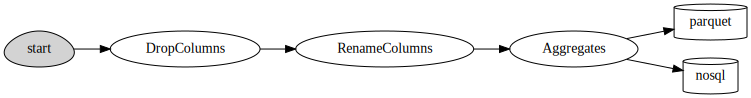

In [21]:
# Configure the list of columns to drop from
# the raw data
drop_columns = ['hr_is_error',
                'rr_is_error',
                'spo2_is_error',
                'movements_is_error',
                'turn_count_is_error',
                'is_in_bed_is_error']

# Define the computationala graph including our custom functions
early_sense_set.graph.to(DropColumns(drop_columns), after='start')\
    .to(RenameColumns(mapping={'bad': 'bed'}))

# Add real-time aggreagations on top of our sensor readings
for col in ['hr', 'rr', 'spo2', 'movements', 'turn_count']:
    early_sense_set.add_aggregation(col + "_h", col, ['avg', 'max', 'min'], "1h")
    early_sense_set.add_aggregation(col + "_d", col, ['avg', 'max', 'min'], "1d")
early_sense_set.add_aggregation('in_bed_h', 'is_in_bed', ['avg'], "1h")
early_sense_set.add_aggregation('in_bed_d', 'is_in_bed', ['avg'], "1d")


# Set NoSQL and Parquet default targets
early_sense_set.set_targets()

# Plot the pipeline
early_sense_set.plot(rankdir='LR', with_targets=True)

### Test/debug the real-time pipeline locally in the notebook

In [22]:
# infer schema + stats, show the final feature set (after the data pipeline)
early_sense_df = pd.read_parquet('https://s3.wasabisys.com/iguazio/data/patients/early_sense.parquet')
early_sense_df['timestamp'] = pd.to_datetime(early_sense_df['timestamp'])
early_sense_df = move_timestamps(early_sense_df) # update timestamps
fs.infer(early_sense_set, early_sense_df.head())

,hr_h_min_1h,hr_h_max_1h,hr_h_avg_1h,hr_d_min_1d,hr_d_max_1d,hr_d_avg_1d,rr_h_min_1h,rr_h_max_1h,rr_h_avg_1h,rr_d_min_1d,...,department,room,hr,rr,spo2,movements,turn_count,is_in_bed,timestamp,bed
patient_id,,,,,,,,,,,,,,,,,,,,,
622-37-0180,220.0,220.0,220.0,220.0,220.0,220.0,25,25,25,25,...,01e9fe31-76de-45f0-9aed-0f94cc97bca0,1,220.0,25,99,0.000000,3.000000,1,2021-05-04 17:54:18.683077,69
838-21-8151,220.0,220.0,220.0,220.0,220.0,220.0,5,5,5,5,...,01e9fe31-76de-45f0-9aed-0f94cc97bca0,1,220.0,5,85,0.000000,0.000000,1,2021-05-04 17:54:18.683077,38
305-90-1613,220.0,220.0,220.0,220.0,220.0,220.0,25,25,25,25,...,01e9fe31-76de-45f0-9aed-0f94cc97bca0,2,220.0,25,99,7.859633,3.000000,1,2021-05-04 17:54:18.683077,95
311-12-1668,220.0,220.0,220.0,220.0,220.0,220.0,25,25,25,25,...,01e9fe31-76de-45f0-9aed-0f94cc97bca0,1,220.0,25,99,10.000000,1.172410,1,2021-05-04 17:54:18.683077,76
584-74-3407,220.0,220.0,220.0,220.0,220.0,220.0,25,25,25,25,...,01e9fe31-76de-45f0-9aed-0f94cc97bca0,2,220.0,25,99,10.000000,0.607354,1,2021-05-04 17:54:18.683077,47


In [23]:
# Run ingest pipeline
df=fs.ingest(early_sense_set, early_sense_df)

# Save the early-sense Featureset
early_sense_set.save()

# print the FeatureSet spec
print(early_sense_set.status.targets.to_dict())

[{'name': 'parquet', 'kind': 'parquet', 'path': 'v3io:///projects/fsdemo-admin/fs/parquet/sets/early_sense-latest.parquet', 'status': 'created', 'updated': '2021-05-06T15:27:46.222973+00:00'}, {'name': 'nosql', 'kind': 'nosql', 'path': 'v3io:///projects/fsdemo-admin/fs/nosql/sets/early_sense-latest', 'status': 'created', 'updated': '2021-05-06T15:27:46.223349+00:00'}]


### Deploy as Real-Time Stream Processing Function (Nuclio Serverless)

Features are not static. For example, it is common that features include different aggregations that need to be updated as data continues to flow. A real-time pipeline requires this data to be up date. Therefore, we need a convenient way to ingest data, not just as batch, but per specific input.

MLRun can convert any code to a real-time serverless function, including the pipeline. This is done by performing the following steps:
1. Define a source, in this case it's an HTTP source
2. Convert the previously defined code to a serving function
3. Create a configuration to run the function
4. Deploy an ingestion service with the Featureset, source and the configuration

In [24]:
# Set a new HTTPSource, this will tell our ingestion service
# to setup a Nuclio function to act as the rest endpoint
# to which we would receive the data
source = HttpSource(key_field='patient_id', time_field='timestamp')

# Take the relevant code parts from this notebook and create
# an MLRun function from them so we can run the pipeline
# as a Nuclio function
func = mlrun.code_to_function("ingest", kind="serving")
nuclio_config = fs.RunConfig(function=func, local=False).apply(mlrun.platforms.auto_mount())

# Deploy the Online ingestion service using the pipeline definition from before
# with our new HTTP Source and our define Function
server = fs.deploy_ingestion_service(early_sense_set, source, run_config=nuclio_config)

> 2021-05-06 15:29:52,032 [info] Starting remote function deploy
2021-05-06 15:29:52  (info) Deploying function
{'level': 'info', 'message': 'Deploying function', 'name': 'fsdemo-admin-ingest', 'time': 1620314992169.7139}
2021-05-06 15:29:52  (info) Building
{'level': 'info', 'message': 'Building', 'name': 'fsdemo-admin-ingest', 'time': 1620314992169.7478, 'versionInfo': 'Label: 1.5.16, Git commit: ae43a6a560c2bec42d7ccfdf6e8e11a1e3cc3774, OS: linux, Arch: amd64, Go version: go1.14.3'}
2021-05-06 15:29:52  (info) Staging files and preparing base images
{'level': 'info', 'message': 'Staging files and preparing base images', 'name': 'deployer', 'time': 1620314992237.7905}
2021-05-06 15:29:52  (info) Building processor image
{'imageName': 'fsdemo-admin-fsdemo-admin-ingest-processor:latest', 'level': 'info', 'message': 'Building processor image', 'name': 'deployer', 'time': 1620314992238.347}
2021-05-06 15:29:55  (info) Build complete
{'level': 'info', 'message': 'Build complete', 'name': 

Test the function by sending data to the HTTP endpoint

In [25]:
test_data = {'patient_id': '838-21-8151',
 'bad': 38,
 'department': '01e9fe31-76de-45f0-9aed-0f94cc97bca0',
 'room': 1,
 'hr': 220.0,
 'hr_is_error': True,
 'rr': 5,
 'rr_is_error': True,
 'spo2': 85,
 'spo2_is_error': True,
 'movements': 0.0,
 'movements_is_error': True,
 'turn_count': 0.0,
 'turn_count_is_error': True,
 'is_in_bed': 1,
 'is_in_bed_is_error': False,
 'timestamp': 1606843455.906352
}

In [26]:
import requests
import json
response = requests.post(server, json=test_data)

In [27]:
response.text

'{"id": "6cc2b746-8b4c-4150-bc7c-d338733b2d5f"}'

## Ingest labels

Finally, we define label data, this will be useful in the next notebook where we train a model

### Create Labels Set

In [28]:
# Define labels metric from the early sense error data
error_columns = [c for c in early_sense_df.columns if 'error' in c]
labels = early_sense_df.loc[:, ['patient_id', 'timestamp'] + error_columns]
labels['label'] = labels.apply(lambda x: sum([x[c] for c in error_columns])>(len(error_columns)*0.7), axis=1)
labels.to_parquet(data_path + 'labels.parquet')

In [29]:
#labels_df = pd.read_parquet('labels.parquet')
labels_set = fs.FeatureSet("labels", entities=[fs.Entity("patient_id")], timestamp_key='timestamp',
                           description="training labels")
labels_set.set_targets()
df = fs.infer(labels_set, data_path + 'labels.parquet')

Converting input from bool to <class 'numpy.uint8'> for compatibility.


In [30]:
df.head()

,patient_id,timestamp,hr_is_error,rr_is_error,spo2_is_error,movements_is_error,turn_count_is_error,is_in_bed_is_error,label
0,622-37-0180,2021-05-04 17:54:18.683077,False,False,False,False,False,False,False
1,838-21-8151,2021-05-04 17:54:18.683077,True,True,True,True,True,False,True
2,305-90-1613,2021-05-04 17:54:18.683077,False,False,False,False,False,False,False
3,311-12-1668,2021-05-04 17:54:18.683077,False,False,False,False,False,False,False
4,584-74-3407,2021-05-04 17:54:18.683077,False,False,False,False,False,False,False


In [31]:
df = fs.ingest(labels_set, data_path + 'labels.parquet')

Converting input from bool to <class 'numpy.uint8'> for compatibility.


In [32]:
labels_set.save()

## Done!

You've completed the data ingestion & prepration. Proceed to [Part 2](02-create-training-model.ipynb) to train a model using these features.